---
title: Step 04 - Modeling
subject: Churn Analysis
subtitle: Step 03 - Modeling - Churn Analysis
short_title: Modeling
date: 2025-12-17

affiliations:
  - id: "ucb"
    name: "University of California, Berkeley"

authors:
  - name: Jocelyn Perez
    affiliations: ["ucb"]
    email: jocelyneperez@berkeley.edu
    orcid: 0009-0009-0231-9254

  - name: Claire Kaoru Shimazaki
    affiliations: ["ucb"]
    email: ckshimazaki@berkeley.edu
    orcid: 0009-0001-0828-3370

  - name: Colby Zhang
    affiliations: ["ucb"]
    email: colbyzhang@berkeley.edu
    orcid: 0009-0005-4786-6922

  - name: Olorundamilola Kazeem
    affiliations: ["ucb"]
    email: dami@berkeley.edu
    orcid: 0000-0003-2118-2221

# https://mystmd.org/guide/frontmatter#frontmatter-downloads
# https://mystmd.org/guide/website-downloads
# downloads:
#   -  ...

# https://mystmd.org/guide/website-downloads#include-exported-pdf
# exports:
#   - format: pdf
#     template: lapreprint-typst
#     output: exports/my-document.pdf
#     id: my-document-export
# downloads:
#   - id: my-document-export
#     title: A PDF of this document

exports:
  - format: pdf
    template: lapreprint-typst
    output: ../pdf_builds/step04_modeling/step04_modeling_ipynb_to.pdf
    line_numbers: true

license: CC-BY-4.0

keywords: modeling, churn, spotify

abstract: What are the models? How are we modeling?
---

In step 03, we translated raw logs into **Behavioral Signals** (e.g. ad tolerance and engagement intensity). The goal of this step is to use these features to predict whether a user will **churn** or **remain active**.

In this notebook, we focused on three task:
- **Baseline Model**: We start with **Logistic Regression** to establish a baseline level of perofrmance. This model provides a simple, interpretable reference point.
- **Class Imbalance**: Churners make up a minority of users, so accuracy alone can be misleading. To prevent the model from defaulting to predicting "non-churn," we apply **class weighting** to account for the imbalance between classes.
- **Random Forest Model**: We then train a **Random Forest Classifer** to capture non-linear relationship between behavioral features. This allows the model to learn interaction effecs that a linear model may miss.


In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import src.step00_utils as step00
import src.step03_features as step03

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# DATA_DIR = Path('../data/02_vectorized')
DATA_DIR = step00.DIR_DATA_02_VECTORIZED
TRAIN_PATH = DATA_DIR / 'train.joblib'
TEST_PATH = DATA_DIR / 'test.joblib'
# FIG_DIR = step03.DIR_DATA.parent / "fig_builds" / "step04_modeling"
FIG_DIR = step00.DIR_OUTPUTS_FIG_BUILDS_04_MODELING
# set seed
RANDOM_STATE = 42

In [3]:
train_data = joblib.load(TRAIN_PATH)
test_data = joblib.load(TEST_PATH)

X_train = train_data['X']
y_train = train_data['y']

X_test = test_data['X']
y_test = test_data['y']

print(f"Training Shape: {X_train.shape}")
print(f"Test Shape:     {X_test.shape}")

Training Shape: (6400, 26)
Test Shape:     (1600, 26)


### Baseline Model (Logistic Regression)

We begin with **Logistic Regression** to establish a baseline level of performance. This model assumes a linear relationship between the behavioral features (e.g., `ads_per_song`, engagement metrics) and the probability of churn.

Because churners represent a minority of users, we use `class_weight='balanced'` to penalize misclassification of the churn class more heavily. This prevents the model from achieving artificially high accuracy by predicting “non-churn” for most users.

In [4]:
# logistic regression
baseline = LogisticRegression(
    max_iter=1000, 
    random_state=RANDOM_STATE,
    class_weight='balanced'
)
baseline.fit(X_train, y_train)
print(f"Baseline Accuracy: {baseline.score(X_test, y_test):.4f}")

Baseline Accuracy: 0.5156


### Random Forest Model

User behavior is unlikely to follow a purely linear pattern. Certain features may only become predictive of churn when combined with others (for example, high ad exposure may matter more for users with low engagement).

To capture these non-linear relationships, we train a **Random Forest Classifier**. As an ensemble of decision trees, the Random Forest can model interaction effects that Logistic Regression cannot.

We use **GridSearchCV** to tune key hyperparameters, allowing us to balance model complexity and generalization performance.

In [5]:
# random forest
rf = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced')

# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}

print("\ngrid search for random forest")
grid_search = GridSearchCV(
    rf, 
    param_grid, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nbest params: {grid_search.best_params_}")
print(f"best CV score: {grid_search.best_score_:.4f}")

final_model = grid_search.best_estimator_


grid search for random forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits

best params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
best CV score: 0.2042


### Model Evaluation

In churn prediction, accuracy alone is not sufficient. Since most users do not churn, a model that always predicts “non-churn” can achieve high accuracy while providing little practical value.

To properly evaluate performance, we examine:
- The **classification report**, which summarizes precision, recall, and F1-score for each class
- The **Confusion Matrix**, to understand the types of errors the model makes

These metrics allow us to assess how well the model identifies churners without excessively misclassifying retained users.


              precision    recall  f1-score   support

           0       0.75      0.80      0.77      1186
           1       0.28      0.22      0.25       414

    accuracy                           0.65      1600
   macro avg       0.52      0.51      0.51      1600
weighted avg       0.63      0.65      0.64      1600



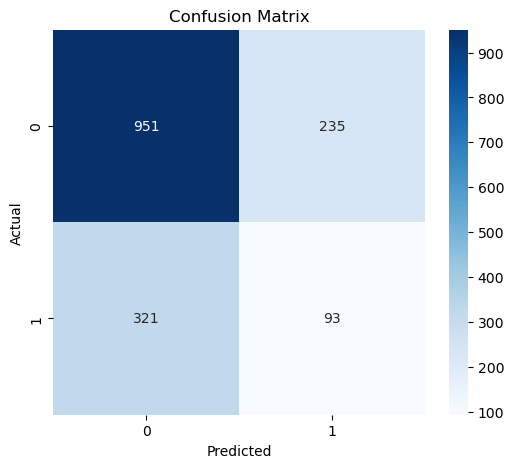

In [6]:
y_pred = final_model.predict(X_test)

# report
print(classification_report(y_test, y_pred))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig(FIG_DIR / 'step04_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

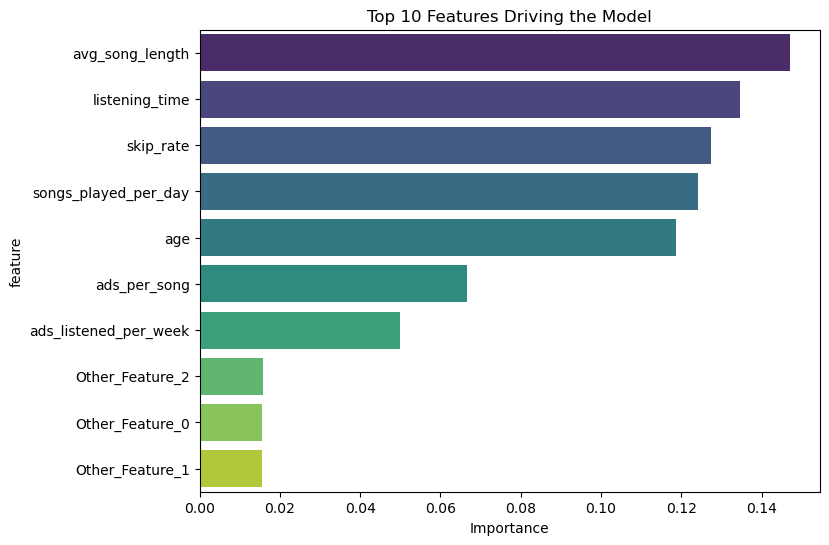

In [7]:
feature_names = [
    "age", 
    "listening_time", 
    "songs_played_per_day", 
    "skip_rate", 
    "ads_listened_per_week", 
    "ads_per_song", 
    "avg_song_length"
]

# generic labels for categorical variables (e.g. one-hot encoded countries)
if X_train.shape[1] > len(feature_names):
    feature_names += [f"Other_Feature_{i}" for i in range(X_train.shape[1] - len(feature_names))]

importances = final_model.feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x='importance', y='feature', hue='feature', legend=False, data=feat_imp, palette='viridis')
plt.title('Top 10 Features Driving the Model')
plt.xlabel('Importance')
plt.savefig(FIG_DIR / 'step04_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

Our analysis reveals that **behavioral engagement is the primary driver of churn**, significantly outweighing static demographic traits. The model relies mostly heavily on **Average Song Length** and **Listening Time**, indicating that users who listen to songs in their entirely (deep engagement) are far more likely to retain their subscrption than those who frequently skip. **Skip Rate** appears as a critical friction signal, confirming that dissatisfaction with content is a leading indicator of departure. Notably, **Age** is the only demographic factor in the top five, suggesting that while usage habits are dominant, the generational culture and budget constraints assocaited with a user's stage in life are still fundamental predictors of retention.

However, despite these insights, our predictive power remains modest (F1-score ~0.25). This aligns with prior research (Verbeke et al., 2012; Ascarza, 2018), which suggests that churn is notoriously difficult to predict. The decision to leave is often driven by **unpredictable events** (like a lost job or a competitor's sudden offer) and **hidden personal factors** that our dataset simply does not capture. These external forces create a "ceiling" on how accurate any model can be, confirming that behavioral data is necessary, but not always sufficient, to predict every individual outcome.